In [48]:
!uv pip install jupyterlab-vim

Sourcing .zshenv...
Using Python 3.12.10 environment at: /home/flynn/repos/work/mbo_utilities/.venv
Audited 1 package in 12ms


In [49]:
import mbo_utilities as mbo
import fastplotlib as fpl
from suite2p.io import BinaryFile

In [50]:
import numpy as np
from scipy.ndimage import fourier_shift
from skimage.registration import phase_cross_correlation

In [63]:
import lbm_suite2p_python as lsp
mdata = lsp.load_ops("/home/flynn/lbm_data/assembled/roi2/plane7/ops.npy")
mdata['num_frames']

220

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
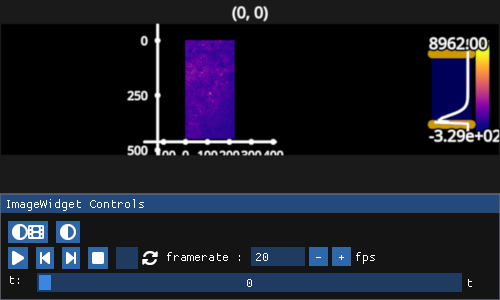

In [46]:
data7 =  tifffile.memmap("/home/flynn/lbm_data/bigtemp2/plane11.tif")
fpl.ImageWidget([data7]).show()

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
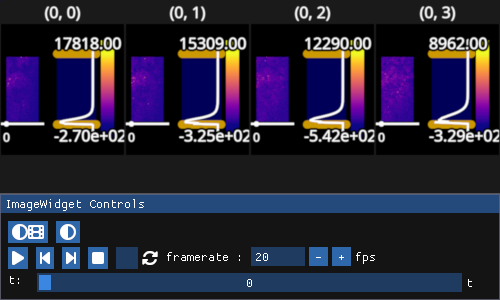

In [44]:
import tifffile
data7 =  tifffile.memmap("/home/flynn/lbm_data/assembled/roi2/plane7.tif")
data8 =  tifffile.memmap("/home/flynn/lbm_data/assembled/roi2/plane8.tif")
data10 =  tifffile.memmap("/home/flynn/lbm_data/assembled/roi2/plane10.tif")
data11 =  tifffile.memmap("/home/flynn/lbm_data/assembled/roi2/plane11.tif")

fpl.ImageWidget([data7, data8, data10, data11], figure_shape=(1, 4)).show()

In [36]:
from pprint import pprint
mdata = np.load("/home/flynn/lbm_data/assembled/roi1/plane11/ops.npy", allow_pickle=True).item()
# mdata = np.load("/home/flynn/lbm_data/tif/roi2/results_testing/ops.npy", allow_pickle=True).item()
mdata_short = mdata.pop("si")

In [11]:
raw_files = mbo.get_files("/home/flynn/lbm_data/raw",max_depth=3)
raw_files

['/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00004.tif',
 '/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00002.tif',
 '/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00010.tif',
 '/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00008.tif',
 '/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00005.tif',
 '/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00001.tif',
 '/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00000.tif',
 '/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00009.tif',
 '/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00003.tif',
 '/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00006.tif',
 '/home/flynn/lbm_data/raw/mk3

In [92]:
scan = mbo.read_scan("/home/flynn/lbm_data/raw", roi=2)

ic| record.getMessage(): 'MBO Scan initialized.'


In [93]:
data = scan[:, 11, :, :]
data.shape

(1437, 448, 224)

In [94]:
offsets = np.zeros(scan.num_frames, dtype=np.float32)
offsets.shape

(1437,)

In [ ]:
offsets = compute_scan_phase_offsets(scan[:, 11, :, :], upsample=10, border=0, max_offset=1)
offsets

In [55]:
frames = apply_scan_phase_offsets(scan[:, 11, :, :], offsets)

In [50]:
bad_indices = [i for i, off in enumerate(offsets) if abs(off) > 2]
bad_indices

[209, 210, 506, 533]

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
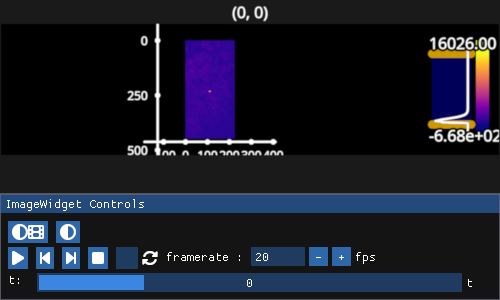

In [56]:
fpl.ImageWidget(frames[bad_indices]).show()

In [18]:
with tifffile.TiffFile(files[0], is_scanimage=False) as tif:
    
    data = tif.asarray()
    h, w = data.shape[1:]
    dtype = data.dtype

    bytes_per_frame = h * w * np.dtype(dtype).itemsize
    max_frames = (50 * 1024**2) // bytes_per_frame  # 50 MB
    sliced = data[:max_frames]
    
print(sliced.shape)

(128, 912, 224)


In [19]:
with open(files[0], 'rb') as f:
    frame_data, roi_data, version = read_scanimage_metadata(f)

    frame_bytes = sliced.shape[1] * sliced.shape[2] * np.dtype(sliced.dtype).itemsize
    max_frames = int((50 * 1024**2) // frame_bytes)
    sliced = full_data[:max_frames]

In [30]:
from tifffile import TiffWriter
import struct
import json

save_path = Path().cwd().parent.joinpath("data")
save_file = save_path.joinpath("demo.tif")

In [51]:
def matlabstr(obj):
    """Convert Python dict to ScanImage-style MATLAB string."""
    def _format(v):
        if isinstance(v, list):
            if all(isinstance(i, str) for i in v):
                return '{' + ' '.join(f"'{i}'" for i in v) + '}'
            return '[' + ' '.join(str(i) for i in v) + ']'
        if isinstance(v, str):
            return f"'{v}'"
        if isinstance(v, bool):
            return 'true' if v else 'false'
        return str(v)

    return '\n'.join(f"{k} = {_format(v)}" for k, v in obj.items())


In [37]:
sp = r"C:\Users\RBO\repos\mbo_utilities\data"
with open(save_file, 'wb') as f:
    # Write ScanImage header manually
    f.write(struct.pack('<2sH', b'II', 43))  # BigTIFF header
    f.seek(16)

    # Fake ScanImage metadata block (exactly like original)
    metadata_bin = bytearray()
    metadata_bin += struct.pack('<IIII', 117637889, version, 0, 0)  # placeholder sizes

    # Serialize static + ROI metadata
    # static_txt = tifffile.matlabstr2py(frame_data).encode('utf-8') + b'\0'
    static_txt = matlabstr(frame_data).encode('utf-8') + b'\0'

    roi_txt = json.dumps(roi_data, separators=(',', ':')).encode('utf-8')

    size0 = len(static_txt)
    size1 = len(roi_txt)
    metadata_bin[8:16] = struct.pack('<II', size0, size1)
    metadata_bin += static_txt
    metadata_bin += roi_txt

    # Write metadata
    f.write(metadata_bin)

    offset_to_first_ifd = f.tell()

In [39]:
type(f)

_io.BufferedWriter

In [55]:
import tifffile
import numpy as np
import shutil

def trim_tiff_frames(input_path, output_path, max_frames=20):
    # Copy original file to preserve metadata
    shutil.copyfile(input_path, output_path)

    with tifffile.TiffFile(input_path, is_scanimage=False) as tif:
        data = tif.asarray()[:max_frames]

    with tifffile.TiffWriter(output_path, bigtiff=True, append=True) as tif_writer:
        for frame in data:
            tif_writer.write(
                frame,
                contiguous=False,
                metadata=None,
                software=None,
                description=None
            )


In [58]:
output_path= r"..\data\scanimage_trimmed.tif"
new = tifffile.imread(output_path)

<tifffile.TiffFile 'scanimage_trimmed.tif'> ScanImage series raised ValueError('unable to determine framesPerSlice')


In [11]:
files = mbo.get_files(fname, 'tif', 1)
files

['D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00000.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00001.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00002.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00003.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00004.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00005.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00006.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00007.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk30

In [16]:
data = tifffile.memmap(files[6])

In [101]:
npy_file = np.memmap("/home/flynn/lbm_data/mk301/roi2/plane6/data_raw.bin", dtype=np.int16, shape=(mdata["Lx"], mdata["Ly"]))

In [104]:
from suite2p.io import BinaryFile
# nframes, Lx, Ly = self.metadata["nframes"], self.metadata["Lx"], self.metadata["Ly"]

In [4]:

def run_plane_bin(plane_dir):
    plane_dir = Path(plane_dir)
    ops_path = plane_dir / "ops.npy"
    if ops_path.exists():
        _ = ic(f"Loading ops from existing file: {ops_path}")
        ops = load_ops(str(ops_path))
    else:
        raise ValueError(f"Invalid ops path: {ops_path}")

    # ops.update(input_format="binary", delete_bin=False, move_bin=False)
    if "nframes" in ops and "n_frames" not in ops:
        ops["n_frames"] = ops["nframes"]
    if "n_frames" not in ops:
        raise KeyError("run_plane_bin: missing frame count (nframes or n_frames)")
    n_frames = ops["n_frames"]

    Ly, Lx = ops["Ly"], ops["Lx"]

    ops["raw_file"] = str((plane_dir / "data_raw.bin").resolve())
    ops["reg_file"] = str((plane_dir / "data.bin").resolve())

    with suite2p.io.BinaryFile(Ly=Ly, Lx=Lx, filename=ops["reg_file"], n_frames=n_frames) as f_reg, \
            suite2p.io.BinaryFile(Ly=Ly, Lx=Lx, filename=ops["raw_file"], n_frames=n_frames) \
                    if "raw_file" in ops and ops["raw_file"] is not None else nullcontext() as f_raw:
    return ops
iw.close()

In [22]:
fig = fpl.Figure()
volume = fig[0,0].add_image_volume(data=data[:500])

# volume.interpolation = "linear"
volume.cmap = "gnuplot2"

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
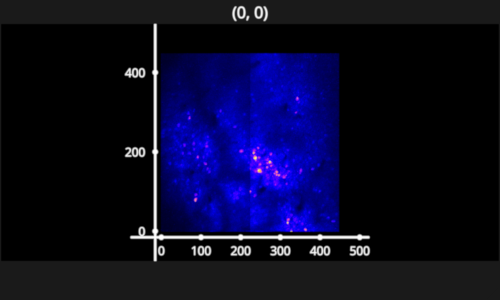

In [23]:
fig.show()

In [9]:
fname_scan = r"D:\W2_DATA\kbarber\2025_03_01\mk301\green\*"
raw_scan = mbo.read_scan(fname_scan)

Detected possible escaped characters in the path. Use a raw string (r'...') or double backslashes.


In [52]:
mbo.save_as(raw_scan, r"D:\W2_DATA\kbarber\2025_03_01\mk301\assembled_zarr", planes=[0, 7, 13], ext=".zarr")

Reading tiff series data...
Reading tiff pages...
Raw tiff fully read.


Saving plane 1:   0%|          | 0/216 [00:00<?, ?it/s]

num-chunks: 216


Saving plane 8:   0%|          | 0/216 [00:00<?, ?it/s]

num-chunks: 216


Saving plane 14:   0%|          | 0/216 [00:00<?, ?it/s]

num-chunks: 216
Time elapsed: 0 minutes 33 seconds.


In [64]:
import tempfile
import shutil
from pathlib import Path
from typing import Dict

import numpy as np
from mbo_utilities.file_io import read_scan
from mbo_utilities._writers import save_as

def compare_fix_phase(
    scan_path: str | Path,
    save_kwargs: dict = None
) -> Dict[bool, float]:
    """
    Load a Scan_MBO from `scan_path`, run `save_as` twice—once with fix_phase=False,
    once with fix_phase=True—saving into a temporary directory each time, then return
    the single scalar offset computed in each case.  Finally, delete the temp directories.

    Parameters
    ----------
    scan_path : str or Path
        Path (or wildcard) pointing to a ScanImage TIFF sequence or folder to read.
    save_kwargs : dict, optional
        Any additional keyword arguments to pass to `save_as` (except `scan` and `savedir`).
        For example: {"planes": [1,2], "ext": ".tiff", "overwrite": True}

    Returns
    -------
    Dict[bool, float]
        A dict mapping {False: offset_without_phase, True: offset_with_phase}.  Each offset
        is the single‐float phase‐correction value computed (via `scan.offset`) when
        fix_phase was set to that boolean.
    """
    if save_kwargs is None:
        save_kwargs = {}

    results: Dict[bool, float] = {}
    # We'll re‐read the scan afresh each time into its own temp dir.
    for fix in (False, True):
        # 1) Make a temp directory
        tmpdir = Path(tempfile.mkdtemp(prefix="mbo_fixphase_"))
        try:
            # 2) Read the scan (lazily) and set fix_phase
            scan = read_scan(scan_path, fix_phase=fix)
            scan.fix_phase = fix

            # 3) Call save_as, redirecting output into tmpdir
            save_as(
                scan,
                savedir=tmpdir,
                **save_kwargs
            )

            # 4) After save_as runs, the scan.offset property should hold a single scalar
            #    If for some reason offset is still an array, take its mean.
            off = getattr(scan, "offset", None)
            if isinstance(off, np.ndarray):
                off = float(np.mean(off))
            elif isinstance(off, (int, float)):
                off = float(off)
            else:
                # If offset wasn’t set at all, default to 0.0
                off = 0.0

            results[fix] = off

        finally:
            # 5) Clean up the temp directory
            shutil.rmtree(tmpdir)

    return results


In [55]:
zpath = r"D:\W2_DATA\kbarber\2025_03_01\mk301\assembled_zarr"
arr = mbo.zarr_to_dask(zpath)